In [23]:
import traceback
import logging
import typing as t

import os
import shutil
import sys
import matplotlib.pyplot as plt

from pathlib import Path

import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns

from importlib import reload

from IPython.display import clear_output

# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

logger = logging.getLogger()
logger.setLevel(logging.INFO)

%matplotlib inline
%config InlineBackend.figure_format='retina'
sys.path.append('/home/developer/python_libs/')
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

## Charging/discharging optimization using MPC

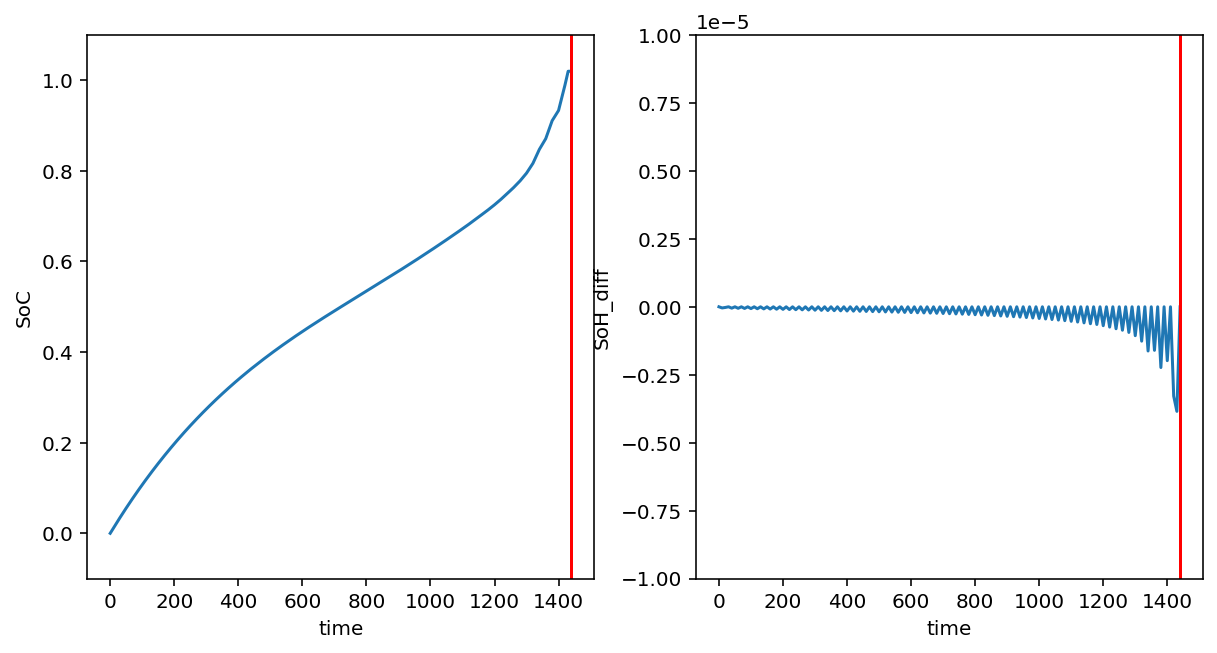

INFO:root:Stopped optimization due to early stopping
 99%|█████████▉| 142/143 [00:00<00:00, 400.10it/s]


In [24]:
from mpc_optimization.battery_model_constants import Battery_state_vars, State_vars_aliases_dict, C_rate_per_second
from mpc_optimization.fmu_source import FmuSource, ModelicaModelInfo
from mpc_optimization.mpc_optimizer import MPCOptimizer, ModelVariables
import mpc_optimization.mpc_optimizer
import mpc_optimization.battery_model_constants
import mpc_optimization.fmu_source
reload(mpc_optimization.mpc_optimizer)
reload(mpc_optimization.battery_model_constants)
reload(mpc_optimization.fmu_source)


mpc_optimizer = MPCOptimizer(
    model_info=ModelicaModelInfo(Path("/home/developer/modelica/BatteryWithFullCycle.mo"),
                                 "BatteryMPC.BatteryWithFullCycle"),
    fmu_path="/home/developer/ipynotebooks/BatteryMPC.BatteryWithFullCycle.fmu",
    initial_parameters={
        'theveninBasedBattery.coulombSocCounter.SOC_init.k': 0
    },
    state_variables=Battery_state_vars,
    input_vec=['I_req'],
    output_vec=['SoC', 'SoH'],
    horizon_num=30,
    points_per_sec=.1
)

start_time = 0
final_time = 60*60
control_df = pd.DataFrame({"Time": range(start_time, final_time)})
control_df['I_req'] = 0
control_df.set_index('Time', inplace=True)

ws = np.geomspace(1e-3, 1e3, 7)
# w = ws[6]*50000 # -- for discharging
# 3-12
w = ws[6]*30# -- for charging
# w = 0

# whole_ref_charge = np.array([0., 0.03133905, 0.06267811, 0.09401716, 0.12535622,
#                        0.15669529, 0.18803435, 0.21936978, 0.25070519, 0.28204061,
#                        0.31337604, 0.34471149, 0.37604695, 0.40738729, 0.43872771,
#                        0.47006816, 0.50140863, 0.53274915, 0.56408971, 0.5954307,
#                        0.62677176, 0.65811289, 0.68945411, 0.72079543, 0.75213687,
#                        0.78347845, 0.8148202, 0.84616213, 0.87750429, 0.90884669,
#                        0.94018939, 0.96527816, 0.99036722, 0.99036902, 0.99037079,
#                        0.99037251])
whole_ref_charge = np.ones(360)

whole_ref_soh_diff = np.ones(len(whole_ref_charge))

whole_ref_soc_2_c = np.array([0., 0.00218717, 0.00437434, 0.00656151, 0.00874868,
                           0.01093585, 0.01312302, 0.01721757, 0.02131354, 0.0254095,
                           0.02950547, 0.03360143, 0.03769739, 0.0438396, 0.04998358,
                           0.05612756, 0.06227154, 0.06841552, 0.0745595, 0.08070351,
                           0.08684751, 0.09299152, 0.09913552, 0.10527953, 0.11142353,
                           0.11756754, 0.12371155, 0.12985556, 0.13599956, 0.14214357,
                           0.14828758, 0.15443087, 0.16057415, 0.16671743, 0.17286072,
                           0.179004, 0.18514728, 0.19129127, 0.19743528, 0.20357929,
                           0.2097233, 0.21586731, 0.22201132, 0.22815533, 0.23429934,
                           0.24044335, 0.24658737, 0.25273138, 0.25887539, 0.2650194,
                           0.27116342, 0.27730743, 0.28345145, 0.28959546, 0.29573948,
                           0.30188349, 0.30802751, 0.31417152, 0.32031554, 0.32645956,
                           0.33260358, 0.3387476, 0.34489162, 0.35103564, 0.35717966,
                           0.36332368, 0.3694677, 0.37561172, 0.38175575, 0.38789977,
                           0.3940438, 0.40018782, 0.40633185, 0.4124744, 0.41861678,
                           0.42475916, 0.43090155, 0.43704393, 0.44318632, 0.44933019,
                           0.45547423, 0.46161826, 0.4677623, 0.47390634, 0.48005038,
                           0.48619442, 0.49233846, 0.4984825, 0.50462655, 0.5107706,
                           0.51691464, 0.52305869, 0.52920275, 0.5353468, 0.54149086,
                           0.54763491, 0.55377897, 0.55992238, 0.56606572, 0.57220906,
                           0.5783524, 0.58449574, 0.59063908, 0.59678304, 0.60292711,
                           0.60907119, 0.61521527, 0.62135936, 0.62750345, 0.63364754,
                           0.63979163, 0.64593573, 0.65207983, 0.65822393, 0.66436803,
                           0.67051168, 0.67665525, 0.68279883, 0.68894241, 0.69508599,
                           0.70122957, 0.70737362, 0.71351776, 0.7196619, 0.72580604,
                           0.73195019, 0.73809435, 0.74423851, 0.75038268, 0.75652685,
                           0.76267102, 0.7688152, 0.77495939, 0.78110357, 0.78724774,
                           0.79339193, 0.79953612, 0.80568031, 0.81182452, 0.8179678,
                           0.8241109, 0.830254, 0.83639711, 0.84254023, 0.84868335,
                           0.85482745, 0.86097174, 0.86711604, 0.87326034, 0.87940466,
                           0.88554899, 0.89169333, 0.89783767, 0.90398203, 0.9101264,
                           0.91627078, 0.92241517, 0.92855958, 0.93470399, 0.94084842,
                           0.94699286, 0.95313732, 0.95928179, 0.96542627, 0.97157077,
                           0.97771528, 0.98385981, 0.99000435])

whole_ref_soh_2_c = np.array([1., 1., 0.99999999, 0.99999998, 0.99999998,
                           0.99999996, 0.99999996, 0.99999995, 0.99999993, 0.99999992,
                           0.9999999, 0.99999988, 0.99999987, 0.99999985, 0.99999982,
                           0.99999979, 0.99999976, 0.99999973, 0.9999997, 0.99999967,
                           0.99999963, 0.9999996, 0.99999956, 0.99999952, 0.99999948,
                           0.99999944, 0.9999994, 0.99999935, 0.99999931, 0.99999926,
                           0.99999921, 0.99999916, 0.99999911, 0.99999905, 0.999999,
                           0.99999894, 0.99999888, 0.99999882, 0.99999876, 0.99999869,
                           0.99999862, 0.99999855, 0.99999848, 0.9999984, 0.99999833,
                           0.99999825, 0.99999816, 0.99999808, 0.99999799, 0.9999979,
                           0.99999781, 0.99999771, 0.99999761, 0.99999751, 0.99999741,
                           0.9999973, 0.99999719, 0.99999707, 0.99999695, 0.99999683,
                           0.9999967, 0.99999657, 0.99999644, 0.9999963, 0.99999616,
                           0.99999602, 0.99999587, 0.99999571, 0.99999555, 0.99999539,
                           0.99999522, 0.99999505, 0.99999487, 0.99999468, 0.9999945,
                           0.9999943, 0.9999941, 0.9999939, 0.99999368, 0.99999347,
                           0.99999324, 0.99999301, 0.99999278, 0.99999253, 0.99999228,
                           0.99999203, 0.99999176, 0.99999149, 0.99999121, 0.99999092,
                           0.99999063, 0.99999032, 0.99999001, 0.99998969, 0.99998936,
                           0.99998903, 0.99998868, 0.99998832, 0.99998796, 0.99998758,
                           0.99998719, 0.99998679, 0.99998639, 0.99998597, 0.99998554,
                           0.99998509, 0.99998464, 0.99998417, 0.9999837, 0.9999832,
                           0.9999827, 0.99998218, 0.99998165, 0.9999811, 0.99998054,
                           0.99997996, 0.99997937, 0.99997877, 0.99997814, 0.99997751,
                           0.99997685, 0.99997618, 0.99997549, 0.99997478, 0.99997405,
                           0.9999733, 0.99997254, 0.99997175, 0.99997095, 0.99997012,
                           0.99996927, 0.9999684, 0.9999675, 0.99996659, 0.99996565,
                           0.99996468, 0.99996369, 0.99996268, 0.99996164, 0.99996057,
                           0.99995947, 0.99995835, 0.9999572, 0.99995602, 0.99995481,
                           0.99995356, 0.99995229, 0.99995098, 0.99994964, 0.99994827,
                           0.99994686, 0.99994542, 0.99994394, 0.99994242, 0.99994086,
                           0.99993926, 0.99993763, 0.99993595, 0.99993423, 0.99993246,
                           0.99993066, 0.9999288, 0.9999269, 0.99992496, 0.99992296,
                           0.99992092, 0.99991882, 0.99991447])

changed = 0

def cost_func(step_num: int, state: pd.DataFrame, input: pd.DataFrame, output: pd.DataFrame) -> float:
    #     print('SoH cost:', -w*np.sum(output[State_vars_aliases_dict['delta_SoH']].values))
    #     print('SoC cost:', np.sum(output[State_vars_aliases_dict['SoC']].values))
    #     print('^^^^^^^^')
    w = ws[6]*11
#     if step_num*20 > 1500:
#         w/= 2
#     if step_num*20 > 1700:
#         w/= 2
#     if step_num*20 > 1900:
#         w/= 2
        
    ref_soc = whole_ref_charge[step_num*2: step_num*2 + len(state)]
    ref_soc = np.concatenate(
        [ref_soc, whole_ref_charge[-1]*np.ones(len(state) - len(ref_soc))])

    ref_soh_diff = whole_ref_soh_2_c[step_num*2: step_num*2 + len(state)]
    
    step = whole_ref_soh_2_c[-2] - whole_ref_soh_2_c[-1]
    appended = np.arange(whole_ref_soh_2_c[-1], whole_ref_soh_2_c[-1]-step*(len(state) - len(ref_soh_diff)), -step)
    ref_soh_diff = np.concatenate([ref_soh_diff, appended])

    output = output.copy()
    output['SoH_diff'] = output['SoH'] - output['SoH'].shift(1, fill_value=1)
    soc_term = np.linalg.norm(output['SoC'] - ref_soc)
    soh_term = w*np.linalg.norm(output['SoH'] - ref_soh_diff)
#     logging.info(f'{soc_term}, {soh_term}')
#     print(output['SoC'].values[:6])
#     print(ref_soc[:6])
    return soc_term + soh_term
#     return -w*np.sum(output['SoH_diff'].shift(1, fill_value=0).values) + \
#         -np.sum(output['SoC'].values)


global state_tmp
state_tmp = None


def visualize_output(step_num: int, states: pd.DataFrame):
    clear_output(wait=True)

    global state_tmp
    if state_tmp is None:
        state_tmp = states
    else:
        state_tmp = state_tmp.append(states)

    state_tmp['SoH_diff'] = state_tmp['SoH'] - \
        state_tmp['SoH'].shift(1, fill_value=1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(data=state_tmp, x='time', y='SoC', ax=axes[0])
    sns.lineplot(data=state_tmp, x='time', y='SoH_diff', ax=axes[1])
    axes[0].axvline((step_num+1)*20, 0, 1, color='red')
    axes[0].set_ylim(-0.1, 1.1)
    axes[1].axvline((step_num+1)*20, 0, 1, color='red')
#     axes[1].set_ylim(0.9999, 1.00001)
    axes[1].set_ylim(-1e-5, 1e-5)
    plt.show()


def stop_if_discharged(step_num: int, state: ModelVariables):
    if state[State_vars_aliases_dict['SoC']] <= 0.01:
        return True
    return False


def stop_if_charged(step_num: int, state: ModelVariables):
    if state[State_vars_aliases_dict['SoC']] >= 0.99:
        return True
    return False


new_control_df = mpc_optimizer.optimize(
    start=0, end=3600, step=20,
    initial_guess=control_df,
    objective_func=cost_func,
    bounds={'I_req': (-10, 10)},
    iteration_callbacks=[visualize_output],
    early_stopping_funcs=[stop_if_charged]
)

states = mpc_optimizer.simulate(
    0, new_control_df.index[-1], new_control_df, save_all=True)

### Charging/discharging optimization using linearization of model

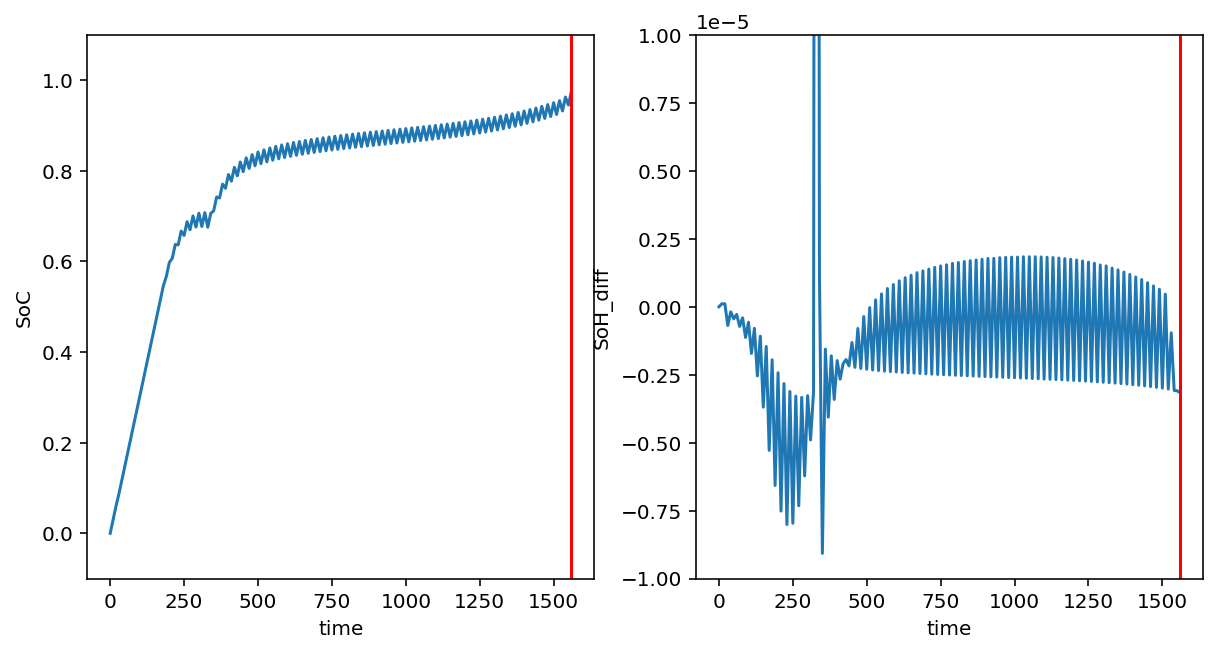

INFO:root:Stopped optimization due to early stopping
 43%|████▎     | 77/180 [42:04<56:17, 32.79s/it]


In [20]:
import mpc_optimization.mpc_optimizer
import mpc_optimization.battery_model_constants
import mpc_optimization.fmu_source
import mpc_optimization.linearization
import mpc_optimization.mpc_optimizer_linear
reload(mpc_optimization.mpc_optimizer)
reload(mpc_optimization.mpc_optimizer_linear)
reload(mpc_optimization.battery_model_constants)
reload(mpc_optimization.fmu_source)
reload(mpc_optimization.linearization)

from mpc_optimization.mpc_optimizer import MPCOptimizer, ModelVariables
from mpc_optimization.mpc_optimizer_linear import MPCOptimizerWithLinearization
from mpc_optimization.fmu_source import FmuSource, ModelicaModelInfo
from mpc_optimization.battery_model_constants import Battery_state_vars, State_vars_aliases_dict, C_rate_per_second
from mpc_optimization.linearization import get_linear_model_matrices

mpc_optimizer = MPCOptimizerWithLinearization(
    model_info=ModelicaModelInfo(Path("/home/developer/modelica/BatteryWithFullCycle.mo"), 
                                "BatteryMPC.BatteryWithFullCycle"),
    initial_parameters={
        'theveninBasedBattery.coulombSocCounter.SOC_init.k': 0
    },
    initial_outputs={
        'SoC': 0,
        'SoH': 1
    },
    horizon_num=10,
    points_per_sec=.1
)


start_time = 0
final_time = 60*60
control_df = pd.DataFrame({"time": range(start_time, final_time)})
control_df['I_req'] = 0
control_df.set_index('time', inplace=True)

ws = np.geomspace(1e-3, 1e3, 7)
# w = ws[6]*50000 # -- for discharging
# 3-12
w = ws[6]*3000# -- for charging
# w = 0

# whole_ref_charge = np.array([0., 0.03133905, 0.06267811, 0.09401716, 0.12535622,
#                        0.15669529, 0.18803435, 0.21936978, 0.25070519, 0.28204061,
#                        0.31337604, 0.34471149, 0.37604695, 0.40738729, 0.43872771,
#                        0.47006816, 0.50140863, 0.53274915, 0.56408971, 0.5954307,
#                        0.62677176, 0.65811289, 0.68945411, 0.72079543, 0.75213687,
#                        0.78347845, 0.8148202, 0.84616213, 0.87750429, 0.90884669,
#                        0.94018939, 0.96527816, 0.99036722, 0.99036902, 0.99037079,
#                        0.99037251])
whole_ref_charge = np.ones(360)

whole_ref_soh_diff = np.ones(len(whole_ref_charge))

whole_ref_soc_2_c = np.array([0., 0.00218717, 0.00437434, 0.00656151, 0.00874868,
                           0.01093585, 0.01312302, 0.01721757, 0.02131354, 0.0254095,
                           0.02950547, 0.03360143, 0.03769739, 0.0438396, 0.04998358,
                           0.05612756, 0.06227154, 0.06841552, 0.0745595, 0.08070351,
                           0.08684751, 0.09299152, 0.09913552, 0.10527953, 0.11142353,
                           0.11756754, 0.12371155, 0.12985556, 0.13599956, 0.14214357,
                           0.14828758, 0.15443087, 0.16057415, 0.16671743, 0.17286072,
                           0.179004, 0.18514728, 0.19129127, 0.19743528, 0.20357929,
                           0.2097233, 0.21586731, 0.22201132, 0.22815533, 0.23429934,
                           0.24044335, 0.24658737, 0.25273138, 0.25887539, 0.2650194,
                           0.27116342, 0.27730743, 0.28345145, 0.28959546, 0.29573948,
                           0.30188349, 0.30802751, 0.31417152, 0.32031554, 0.32645956,
                           0.33260358, 0.3387476, 0.34489162, 0.35103564, 0.35717966,
                           0.36332368, 0.3694677, 0.37561172, 0.38175575, 0.38789977,
                           0.3940438, 0.40018782, 0.40633185, 0.4124744, 0.41861678,
                           0.42475916, 0.43090155, 0.43704393, 0.44318632, 0.44933019,
                           0.45547423, 0.46161826, 0.4677623, 0.47390634, 0.48005038,
                           0.48619442, 0.49233846, 0.4984825, 0.50462655, 0.5107706,
                           0.51691464, 0.52305869, 0.52920275, 0.5353468, 0.54149086,
                           0.54763491, 0.55377897, 0.55992238, 0.56606572, 0.57220906,
                           0.5783524, 0.58449574, 0.59063908, 0.59678304, 0.60292711,
                           0.60907119, 0.61521527, 0.62135936, 0.62750345, 0.63364754,
                           0.63979163, 0.64593573, 0.65207983, 0.65822393, 0.66436803,
                           0.67051168, 0.67665525, 0.68279883, 0.68894241, 0.69508599,
                           0.70122957, 0.70737362, 0.71351776, 0.7196619, 0.72580604,
                           0.73195019, 0.73809435, 0.74423851, 0.75038268, 0.75652685,
                           0.76267102, 0.7688152, 0.77495939, 0.78110357, 0.78724774,
                           0.79339193, 0.79953612, 0.80568031, 0.81182452, 0.8179678,
                           0.8241109, 0.830254, 0.83639711, 0.84254023, 0.84868335,
                           0.85482745, 0.86097174, 0.86711604, 0.87326034, 0.87940466,
                           0.88554899, 0.89169333, 0.89783767, 0.90398203, 0.9101264,
                           0.91627078, 0.92241517, 0.92855958, 0.93470399, 0.94084842,
                           0.94699286, 0.95313732, 0.95928179, 0.96542627, 0.97157077,
                           0.97771528, 0.98385981, 0.99000435])

whole_ref_soh_2_c = np.array([1., 1., 0.99999999, 0.99999998, 0.99999998,
                           0.99999996, 0.99999996, 0.99999995, 0.99999993, 0.99999992,
                           0.9999999, 0.99999988, 0.99999987, 0.99999985, 0.99999982,
                           0.99999979, 0.99999976, 0.99999973, 0.9999997, 0.99999967,
                           0.99999963, 0.9999996, 0.99999956, 0.99999952, 0.99999948,
                           0.99999944, 0.9999994, 0.99999935, 0.99999931, 0.99999926,
                           0.99999921, 0.99999916, 0.99999911, 0.99999905, 0.999999,
                           0.99999894, 0.99999888, 0.99999882, 0.99999876, 0.99999869,
                           0.99999862, 0.99999855, 0.99999848, 0.9999984, 0.99999833,
                           0.99999825, 0.99999816, 0.99999808, 0.99999799, 0.9999979,
                           0.99999781, 0.99999771, 0.99999761, 0.99999751, 0.99999741,
                           0.9999973, 0.99999719, 0.99999707, 0.99999695, 0.99999683,
                           0.9999967, 0.99999657, 0.99999644, 0.9999963, 0.99999616,
                           0.99999602, 0.99999587, 0.99999571, 0.99999555, 0.99999539,
                           0.99999522, 0.99999505, 0.99999487, 0.99999468, 0.9999945,
                           0.9999943, 0.9999941, 0.9999939, 0.99999368, 0.99999347,
                           0.99999324, 0.99999301, 0.99999278, 0.99999253, 0.99999228,
                           0.99999203, 0.99999176, 0.99999149, 0.99999121, 0.99999092,
                           0.99999063, 0.99999032, 0.99999001, 0.99998969, 0.99998936,
                           0.99998903, 0.99998868, 0.99998832, 0.99998796, 0.99998758,
                           0.99998719, 0.99998679, 0.99998639, 0.99998597, 0.99998554,
                           0.99998509, 0.99998464, 0.99998417, 0.9999837, 0.9999832,
                           0.9999827, 0.99998218, 0.99998165, 0.9999811, 0.99998054,
                           0.99997996, 0.99997937, 0.99997877, 0.99997814, 0.99997751,
                           0.99997685, 0.99997618, 0.99997549, 0.99997478, 0.99997405,
                           0.9999733, 0.99997254, 0.99997175, 0.99997095, 0.99997012,
                           0.99996927, 0.9999684, 0.9999675, 0.99996659, 0.99996565,
                           0.99996468, 0.99996369, 0.99996268, 0.99996164, 0.99996057,
                           0.99995947, 0.99995835, 0.9999572, 0.99995602, 0.99995481,
                           0.99995356, 0.99995229, 0.99995098, 0.99994964, 0.99994827,
                           0.99994686, 0.99994542, 0.99994394, 0.99994242, 0.99994086,
                           0.99993926, 0.99993763, 0.99993595, 0.99993423, 0.99993246,
                           0.99993066, 0.9999288, 0.9999269, 0.99992496, 0.99992296,
                           0.99992092, 0.99991882, 0.99991447])

def cost_func(step_num: int, state: pd.DataFrame, input: pd.DataFrame, output: pd.DataFrame) -> float:
    #     print('SoH cost:', -w*np.sum(output[State_vars_aliases_dict['delta_SoH']].values))
    #     print('SoC cost:', np.sum(output[State_vars_aliases_dict['SoC']].values))
    #     print('^^^^^^^^')
    w = ws[6]*11
    if step_num*20 > 1500:
        w/= 2
    if step_num*20 > 1700:
        w/= 2
    if step_num*20 > 1900:
        w/= 2
        
    ref_soc = whole_ref_charge[step_num*2: step_num*2 + len(state)]
    ref_soc = np.concatenate(
        [ref_soc, whole_ref_charge[-1]*np.ones(len(state) - len(ref_soc))])

    ref_soh_diff = whole_ref_soh_2_c[step_num*2: step_num*2 + len(state)]
    
    step = whole_ref_soh_2_c[-11] - whole_ref_soh_2_c[-1]
    appended = np.arange(whole_ref_soh_2_c[-1], whole_ref_soh_2_c[-1]-step*(len(state) - len(ref_soh_diff)), -step)
    ref_soh_diff = np.concatenate([ref_soh_diff, appended])

    output = output.copy()
    output['SoH_diff'] = output['SoH'] - output['SoH'].shift(1, fill_value=1)
    soc_term = np.linalg.norm(output['SoC'] - ref_soc)
    soh_term = w*np.linalg.norm(output['SoH'] - ref_soh_diff)
    logging.info(f'{soc_term}, {soh_term}')
#     print(output['SoC'].values[:6])
#     print(ref_soc[:6])
    return soc_term + soh_term
#     return -w*np.sum(output['SoH_diff'].shift(1, fill_value=0).values) + \
#         -np.sum(output['SoC'].values)

global state_tmp
state_tmp = None

def visualize_output(step_num: int, states: pd.DataFrame):
    clear_output(wait=True)

    global state_tmp
    if state_tmp is None:
        state_tmp = states
    else:
        states = states.copy()
        states['time'] = states['time'] + state_tmp.iloc[-1]['time']
        state_tmp = state_tmp.append(states.iloc[1:])
        
    state_tmp['SoH_diff'] = state_tmp['SoH'] - \
        state_tmp['SoH'].shift(1, fill_value=1)
        
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(data=state_tmp, x='time', y='SoC', ax=axes[0])
    sns.lineplot(data=state_tmp, x='time', y='SoH_diff', ax=axes[1])
    axes[0].axvline((step_num+1)*20, 0, 1, color='red')
    axes[0].set_ylim(-0.1, 1.1)
    axes[1].axvline((step_num+1)*20, 0, 1, color='red')
#     axes[1].set_ylim(0.9999, 1.00001)
    axes[1].set_ylim(-1e-5, 1e-5)
    plt.show()

def stop_if_discharged(step_num: int, state: ModelVariables):
    if state['SoC'] <= 0.01:
        return True
    return False
        
def stop_if_charged(step_num: int, state: ModelVariables):
    if state['SoC'] >= 0.97:
        return True
    return False

new_control_df = mpc_optimizer.optimize(
    start=0, end=3600, step=20,
    initial_guess=control_df, 
    objective_func=cost_func, 
    bounds={'I_req': (-10*C_rate_per_second, 10*C_rate_per_second)},
    iteration_callbacks=[visualize_output],
    early_stopping_funcs=[stop_if_charged]
)

In [21]:
final_optimizer = MPCOptimizer(
    model_info=ModelicaModelInfo(Path("/home/developer/modelica/BatteryWithFullCycle.mo"), 
                                "BatteryMPC.BatteryWithFullCycle"),
    fmu_path="/home/developer/ipynotebooks/BatteryMPC.BatteryWithFullCycle.fmu",
    state_variables=Battery_state_vars,
    input_vec=['I_req'],
    output_vec=['SoC',
                'theveninBasedBattery.SoH'],
    initial_parameters={
        'theveninBasedBattery.coulombSocCounter.SOC_init.k': 0
    },
    horizon_num=10,
    points_per_sec=.1
)
states = final_optimizer.simulate(start_time, new_control_df.index[-1], new_control_df, save_all=True)

res = states.rename(columns={v: k for k, v in State_vars_aliases_dict.items()})
res['U'] *= -1

alt.Chart(res).mark_line().encode(
    x = alt.X('time:Q', title='time(min)'),
    y = alt.Y('SoC:Q', scale=alt.Scale(zero=False), title='SoC'),
    color=alt.Color('type:N', scale=alt.Scale(scheme='set1'))
) &  alt.Chart(res).mark_line().encode(
    x = alt.X('time:Q', title='time(min)'),
    y = alt.Y('SoH:Q', scale=alt.Scale(zero=False), title='SoH'),
    color=alt.Color('type:N', scale=alt.Scale(scheme='set1'))
)

100%|██████████| 155/155 [00:00<00:00, 203.30it/s]


alt.VConcatChart(...)

In [22]:
new_control_df.to_pickle('optimized_charging_linear.pkl')

In [72]:
from scipy.optimize import minimize

A, B, C, D = get_linear_model_matrices(mpc_optimizer.model)

n, m = np.array(B).shape
K = np.zeros(shape=(m, n))

def minimize_func(K):
    K = K.reshape(m, n)
    return np.abs(np.linalg.eigvals(A + np.dot(B, K))).max()

optim = minimize(minimize_func, x0=K)
K_optim = optim.x.reshape(m, n)

0.004187512222098827

In [73]:
(A + np.dot(B, K_optim)).T

array([[-4.18216906e-03,  1.47054847e-05, -1.47054847e-05,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.47054847e-05],
       [ 9.43952741e-02,  3.68591532e-03, -9.43952741e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -9.43952741e-02],
       [-1.38243303e-05, -1.37403688e-05,  1.37436336e-05,
        -5.80692453e-08, -5.80692453e-08,  5.30538650e-08,
         1.37436336e-05],
       [ 7.52486555e-06,  7.80590560e-06, -7.79496645e-06,
        -3.34467598e-03, -1.94378689e-07,  1.77587259e-07,
        -7.79496645e-06],
       [ 7.79496645e-06,  7.79496645e-06, -7.79496645e-06,
         0.00000000e+00, -3.34448161e-03,  3.05556386e-03,
        -7.79496645e-06],
       [-5.42403827e-06, -4.72148120e-06,  4.74880709e-06,
        -4.85924403e-07, -4.85924403e-07, -3.34403766e-03,
         4.74880709e-06],
       [-4.66124341e-03,  1.74317635e-04,  1.37436336e-05,
        -3.34453967e-03, -3.34453967e-03,  3.05561700e-03,
         1.3743633

## SoH Test Cycle

In [ ]:
import mpc_optimization.mpc_optimizer
import mpc_optimization.battery_model_constants
reload(mpc_optimization.mpc_optimizer)
reload(mpc_optimization.battery_model_constants)

from mpc_optimization.mpc_optimizer import MPCOptimizer, FmuSource
from mpc_optimization.mpc_optimizer import MPCOptimizer

from mpc_optimization.battery_model_constants import BatteryStateVars, StateVarsAliasesDict

mpc_optimizer = MPCOptimizer(
    fmu=FmuSource.from_fmu(Path('./BatteryMPC_BatteryWithFullCycle.fmu')),
    state_variables=BatteryStateVars,
    input_vec=['I_req'],
    output_vec=['theveninBasedBattery.coulombSocCounter.SoC', 'theveninBasedBattery.SoH'],
    horizon_num=5,
    mpc_step=60
)

C_bat = 1.1
c_rate_per_second = C_bat/3600
c_rate_cycle = np.concatenate([c_rate_per_second * np.ones(60*60),
                               -c_rate_per_second * np.ones(60*60)])

control_df = pd.DataFrame({'Time': pd.date_range(start='1/1/1970', periods=10*2*60*60, freq='1s'),
                           'I_req': np.tile(c_rate_cycle, 10)
             })

start_time = 0
final_time = len(control_df)

control_df['Time'] = control_df.reset_index()['Time'].values.astype('int')/10**9
control_df = control_df.set_index('Time')

states = mpc_optimizer.simulate(start_time, final_time, control_df, save_all=True)
states[full_var_name['U']] *= -1

states = states.rename(columns={v: k for k, v in full_var_name.items()})

st = 0
en = 40000
st = np.argmin(np.abs(states['time'] - st))
en = np.argmin(np.abs(states['time'] - en))

simulation_res = pd.DataFrame({"time": states['time'][st:en], "SoH": states['SoH'][st:en], 
                                                 "capacityFade": states['capacityFade'][st:en], 
                                                 "stepCapacityFade": states['stepCapacityFade'][st:en],
                                                 "is_charging": 0.00001*states['is_not_charging'][st:en] })

alt.Chart(simulation_res).mark_line().encode(
    x = alt.X('time:Q', title='time(min)'),
    y = alt.Y('SoH:Q', scale=alt.Scale(zero=False), title='U_bat(V)'),
    color=alt.Color('type:N', scale=alt.Scale(scheme='set1'))
) 

## Test cycle simulation

In [7]:
# build modelica fmu
!PYTHONPATH=/usr/local/JModelica/Python/:/usr/local/JModelica/Python/pymodelica/: python2 build_fmu.py

/usr/local/JModelica/lib/RuntimeLibrary/libModelicaMatIO.a(ModelicaMatIO.c.o): In function `Mat_VarDelete':
/usr/local/src/JModelica/ThirdParty/MSL/Modelica/Resources/C-Sources/ModelicaMatIO.c:8521: warning: the use of `mktemp' is dangerous, better use `mkstemp' or `mkdtemp'



In [127]:
import mpc_optimization.mpc_optimizer
import mpc_optimization.battery_model_constants
reload(mpc_optimization.mpc_optimizer)
reload(mpc_optimization.battery_model_constants)

from mpc_optimization.battery_model_constants import Battery_state_vars, State_vars_aliases_dict, C_rate_per_second
from mpc_optimization.fmu_source import FmuSource, ModelicaModelInfo
from mpc_optimization.mpc_optimizer import MPCOptimizer

def get_test_voltage_response(is_charging):
    mpc_optimizer = MPCOptimizer(
        model_info=ModelicaModelInfo(Path("/home/developer/modelica/BatteryWithFullCycle.mo"), 
                                    "BatteryMPC.BatteryWithFullCycle"),
        fmu_path="/home/developer/ipynotebooks/BatteryMPC.BatteryWithFullCycle.fmu",
        state_variables=Battery_state_vars,
        input_vec=['I_req'],
        output_vec=['SoC',
                    'theveninBasedBattery.SoH'],
        horizon_num=5,
        points_per_sec=.1
    )

    test_df = pd.read_csv('plots_data/test_cycle.csv')
    test_df = test_df.rename(columns={'x': 'Time'})
    test_df['y'] = test_df['y']*C_rate_per_second*1.075/1.1
    test_df['Time'] = test_df['Time'].apply(lambda x: max(x, 0))
    test_df['Time'] = pd.to_datetime(test_df['Time'], unit='m')
    test_df = test_df.set_index('Time').resample("s").mean().interpolate(
        method='time', axis=0)

    test_df['Time'] = test_df.reset_index()['Time'].values.astype('int')/10**9
    test_df = test_df.set_index('Time')

    start_time = 0
    final_time = 10140

    states = mpc_optimizer.simulate(start_time, final_time, test_df, save_all=True)
    states[State_vars_aliases_dict['U']] *= -1

    states = states.rename(columns={v: k for k, v in State_vars_aliases_dict.items()})
    var, soc, t = states['U'], states['SoC'], states['time']

    st = np.argmin(np.abs(t - 6500)) if is_charging else 0
    en = np.argmin(np.abs(t - 10000)
                   ) if is_charging else np.argmin(np.abs(t - 3800))
    time = t[st:en]/60-110 if is_charging else t[st:en]/60
    simulation_res = pd.DataFrame({"time": time, "voltage": var[st:en]})
    simulation_res['type'] = 'simulation'
    modifier = ("" if is_charging else "dis") + "charging"
    measurement_output_df = pd.read_csv(
        'plots_data/measurement_' + modifier + '.csv').rename(columns={'x': 'time', 'y': 'voltage'})
    measurement_output_df['type'] = 'measurement'

    return alt.Chart(simulation_res.append(measurement_output_df)).mark_line().encode(
        x=alt.X('time:Q', title='time(min)'),
        y=alt.Y('voltage:Q', scale=alt.Scale(zero=False), title='U_bat(V)'),
        color=alt.Color('type:N', scale=alt.Scale(scheme='set1'))
    )

In [130]:
alt.vconcat(
    get_test_voltage_response(False).properties(
        title='charging'
    ),
    get_test_voltage_response(True).properties(
        title='discharging')
).configure_view(
    height=300,
    width=600
).configure_legend(
    labelFont='CMU Serif',
    titleFont='CMU Serif',
    labelFontSize=17,
    titleFontSize=19,
).configure_axis(
    labelFont='CMU Serif',
    titleFont='CMU Serif',
    labelFontSize=17,
    titleFontSize=19,
)

100%|██████████| 10140/10140 [00:17<00:00, 595.66it/s]


alt.VConcatChart(...)

In [ ]:
## Using PyFMI for simulation

In [24]:
from pyfmi import load_fmu

def full_var_name(name):
    translator = {'time': 'time',
                  'U_ocv': 'theveninBasedBattery.voltageSource.U_ocv.v',
                  'R_ts': 'theveninBasedBattery.R_ts.v',
                  'R_tl': 'theveninBasedBattery.R_tl.v',
                  'I_int': 'theveninBasedBattery.coulombSocCounter.integrator.y',
                  'SoC_int': 'theveninBasedBattery.capacityFadingCalc.socIntegrator.y',
                  'SoC_square_int': 'theveninBasedBattery.capacityFadingCalc.socSquareIntegrator.y',
                  'xi': 'theveninBasedBattery.capacityFadingCalc.capacityFade',
                  'Ah_throughput': 'theveninBasedBattery.capacityFadingCalc.Ah_throughput.y',
                  't_last': 'theveninBasedBattery.capacityFadingCalc.cycleStartTime',
                  'I_req': 'I_req',
                  'SoC': 'theveninBasedBattery.coulombSocCounter.SoC', 
                  'SoH': 'theveninBasedBattery.SoH', 
                  }
    return translator[name]

model = load_fmu('./BatteryMPC-BatteryWithFullCycle.fmu', log_level=4)

C_bat = 1.1
c_rate_per_second = C_bat/3600

start_time = 0
final_time = 24*60*60
control_df = pd.DataFrame({"Time": range(start_time, final_time)})
control_df['I_bat'] = - c_rate_per_second/12
control_df.loc[control_df['Time'] < (
    final_time - start_time)/2, 'I_bat'] = c_rate_per_second/12
control_df.set_index('Time', inplace=True)

model 
model.reset()
model.initialize(start_time=0, stop_time=final_time//8)
opts = model.simulate_options()
opts['ncp'] = 50
opts['initialize'] = False
opts['silent_mode'] = True
# res = model.simulate(start_time, final_time//8, input=('I_req', control_df.reset_index().values[start_time:final_time//4]), options=opts)

# state_vars = list(filter(lambda x: res.is_variable(x), res.keys()))
# states = pd.DataFrame(data=np.array([res[i] for i in state_vars]).T,
#                       columns=state_vars)
# for i in np.arange(final_time//8, final_time, 10000):
#     for j in range(4):
#         model.reset()
#         model.initialize(start_time=i, stop_time=i+10000)
#     #     model.setup_experiment(final_time//4, stop_time=final_time)
#     #     model.initialize()
#         for var in state_vars:
#             if var == 'time':
#                 continue
#             model.set(var, res.final(var))

#         opts = model.simulate_options()
#         opts['ncp'] = 50
#         opts['initialize'] = False
#         opts['silent_mode'] = True

#         res2 = model.simulate(i, i+10000, ('I_req', control_df.reset_index().values[start_time:final_time//4]), options=opts)
#     res = res2

#     states2 = pd.DataFrame(data=np.array([res[i] for i in state_vars]).T,
#                           columns=state_vars)
#     states = states.append(states2)
    
# plt.plot(states['time'], states[full_var_name('U_ocv')])
# plt.xlabel('time in [s]')
# plt.ylabel('volatage response[U]')
# plt.grid()
# plt.show()

FMUException: Exit Initialize returned with an error. Enable logging for more information, (load_fmu(..., log_level=4)).

In [6]:
# model.get_variable_initial('theveninBasedBattery.U_oc.signal_voltage.voltage')
# from pyfmi import get_start_value

# parameters = list(model.get_model_variables(
#                             causality=0,
#                             variability=None, # Parameters
#                             filter='[!_]*'
#                          ).keys())


# {parameter: model.get_variable_start(parameter) for parameter in parameters}
# parameters

list(model.get_model_variables(variability=1, filter='[!_]*').keys())

['C_bat',
 'I_dis',
 'theveninBasedBattery.C_bat',
 'theveninBasedBattery.C_tl.Cmin',
 'theveninBasedBattery.C_tl.IC',
 'theveninBasedBattery.C_ts.Cmin',
 'theveninBasedBattery.C_ts.IC',
 'theveninBasedBattery.R_s.T',
 'theveninBasedBattery.R_s.T_heatPort',
 'theveninBasedBattery.R_s.T_ref',
 'theveninBasedBattery.R_s.alpha',
 'theveninBasedBattery.R_tl.T',
 'theveninBasedBattery.R_tl.T_heatPort',
 'theveninBasedBattery.R_tl.T_ref',
 'theveninBasedBattery.R_tl.alpha',
 'theveninBasedBattery.R_ts.T',
 'theveninBasedBattery.R_ts.T_heatPort',
 'theveninBasedBattery.R_ts.T_ref',
 'theveninBasedBattery.R_ts.alpha',
 'theveninBasedBattery.SocToOcvTableFileName',
 'theveninBasedBattery.U_oc.SOC_to_U_bat.columns[1]',
 'theveninBasedBattery.U_oc.SOC_to_U_bat.fileName',
 'theveninBasedBattery.U_oc.SOC_to_U_bat.tableName',
 'theveninBasedBattery.U_oc.SOC_to_U_bat.tableOnFileRead',
 'theveninBasedBattery.U_oc.SOC_to_U_bat.verboseRead',
 'theveninBasedBattery.U_oc.SocToULookupTableFileName',
 'thev

In [ ]:
theveninBasedBattery.coulombSocCounter.SOC_init.k

## MPCPy optimization

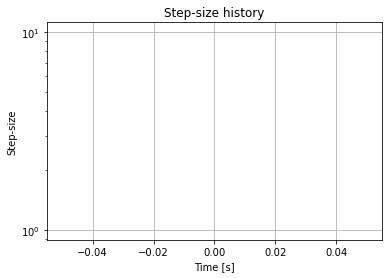

In [11]:
from pyfmi.debug import CVodeDebugInformation
CVodeDebugInformation('BatteryMPC_BatteryWithFullCycle_log.txt').plot_step_size()

### Run Emulation from Modelica file

In [ ]:
from mpcpy import variables, units, exodata
from mpcpy import systems, models, optimization

import pandas as pd
import numpy as np
import altair as alt

from collections import defaultdict 

alt.renderers.enable('notebook')
alt.data_transformers.disable_max_rows()

In [ ]:
soc_setpoint = variables.Static('SoC_setpoint', 1, units.unit1)
soh_setpoint = variables.Static('SoH_setpoint', 1, units.unit1)

In [ ]:
C_bat = 1.1
c_rate_per_second = C_bat/3600

variable_map = {'I_bat': ('I_req', units.unit1) }
control_df = pd.DataFrame({"Time": pd.date_range("1/1/2017", "1/2/2017", freq='s')})
control_df['I_bat'] = - c_rate_per_second/12
control_df.loc[control_df['Time'] < pd.to_datetime("1/1/2017 12:00:00"), 'I_bat'] = c_rate_per_second/12
control_df.set_index('Time', inplace=True)
control = exodata.ControlFromDF(control_df, variable_map)
control.collect_data('1/1/2017', '1/3/2017')

In [ ]:
moinfo = ('/home/developer/modelica/BatteryWithFullCycle.mo',
          'BatteryMPC.BatteryWithFullCycle', {})

measurements = defaultdict(dict)
sample_rate = 1

measurements['theveninBasedBattery.voltageSource.U_ocv.v']['Sample'] = variables.Static(
    'sample_rate_theveninBasedBattery.voltageSource.U_ocv.v', sample_rate, units.s)

measurements['theveninBasedBattery.coulombSocCounter.SoC']['Sample'] = variables.Static(
    'sample_rate_theveninBasedBattery.coulombSocCounter.SoC', sample_rate, units.s)

measurements['theveninBasedBattery.SoH']['Sample'] = variables.Static(
    'sample_rate_theveninBasedBattery.SoH', sample_rate, units.s)

measurements['theveninBasedBattery.I_bat.i']['Sample'] = variables.Static(
    'sample_rate_theveninBasedBattery.I_bat.i', sample_rate, units.s)

In [ ]:
emulation = systems.EmulationFromFMU(measurements, 
                                     moinfo=moinfo,
                                     control_data=control.data
                                    )

In [ ]:
emulation.collect_measurements('1/1/2017', '1/2/2017')

In [ ]:
df = emulation.display_measurements('Measured').reset_index().rename(columns={
    'theveninBasedBattery.voltageSource.U_ocv.v': 'U_ocv', 'theveninBasedBattery.SoH': 'SoH', 
    'theveninBasedBattery.coulombSocCounter.SoC': 'SoC',
    'theveninBasedBattery.I_bat.i': 'I_bat'
})
alt.Chart(df).mark_line(interpolate='step').encode(
    x=alt.X('Time:T', title='time'),
#     y=alt.Y('I_bat:Q', scale=alt.Scale(zero=False), title='I, [A]'),
#     y=alt.Y('U_ocv:Q', scale=alt.Scale(zero=False), title='U, [V]'),
#     y= alt.Y('SoH:Q'),
    y= alt.Y('SoC:Q'),
    #     color=alt.value('red')
).configure_view(
    height=300,
    width=800
).configure_legend(
    labelFont='CMU Serif',
    titleFont='CMU Serif',
    labelFontSize=15,
    titleFontSize=15,
).configure_axis(
    labelFont='CMU Serif',
    titleFont='CMU Serif',
    labelFontSize=15,
    titleFontSize=15,
)

### Run simulation from Modelica (parameters can be estimated)

In [ ]:
parameters = exodata.ParameterFromDF(pd.DataFrame(columns=["Name", "Free", "Value", "Minimum", "Maximum", "Covariance", "Unit"]).set_index('Name'))
parameters.collect_data()
parameters.display_data()

In [ ]:
import imp
imp.reload(models)
imp.reload(optimization)
imp.reload(systems)

In [ ]:
model = models.Modelica(models.JModelicaParameter,
                        models.RMSE,
                        emulation.measurements,
                        moinfo = moinfo,
                        parameter_data = parameters.data,
                        control_data = control.data
                       )

In [ ]:
model.simulate('1/1/2017', '1/2/2017')

In [ ]:
df = model.display_measurements('Simulated').reset_index().rename(columns={
    'theveninBasedBattery.voltageSource.U_ocv.v': 'U_ocv', 'theveninBasedBattery.SoH': 'SoH', 
    'theveninBasedBattery.coulombSocCounter.SoC': 'SoC',
    'theveninBasedBattery.I_bat.i': 'I_bat'
})
alt.Chart(df).mark_line(interpolate='step').encode(
    x=alt.X('Time:T', title='time'),
#     y=alt.Y('I_bat:Q', scale=alt.Scale(zero=False), title='I, [A]'),
#     y=alt.Y('U_ocv:Q', scale=alt.Scale(zero=False), title='U, [V]'),
#     y= alt.Y('SoH:Q'),
    y= alt.Y('SoC:Q'),
    #     color=alt.value('red')
).configure_view(
    height=300,
    width=800
).configure_legend(
    labelFont='CMU Serif',
    titleFont='CMU Serif',
    labelFontSize=15,
    titleFontSize=15,
).configure_axis(
    labelFont='CMU Serif',
    titleFont='CMU Serif',
    labelFontSize=15,
    titleFontSize=15,
)

### Run optimization for battery charging

In [ ]:
from mpcpy import optimization

In [ ]:
variable_map = { 
    "SoC_min": ('theveninBasedBattery.coulombSocCounter.SoC', 'GTE', units.unit1),
    "SoC_max": ('theveninBasedBattery.coulombSocCounter.SoC', 'LTE', units.unit1),
    "SoH_min": ('theveninBasedBattery.SoH', 'GTE', units.unit1),
    "SoH_max": ('theveninBasedBattery.SoH', 'LTE', units.unit1),
    "I_bat_min": ('theveninBasedBattery.I_bat.i', 'GTE', units.unit1),
    "I_bat_max": ('theveninBasedBattery.I_bat.i', 'LTE', units.unit1),
               }

In [ ]:
constraints_df = pd.DataFrame({"Time": pd.date_range("1/1/2017", "1/2/2017", freq='s')})
constraints_df['SoC_min'] = 0
constraints_df['SoC_max'] = 1
constraints_df['SoH_min'] = 0
constraints_df['SoH_max'] = 1
constraints_df['I_bat_min'] = -0.05
constraints_df['I_bat_max'] = 0.05
constraints_df.set_index('Time', inplace=True)

In [ ]:
constraints = exodata.ConstraintFromDF(constraints_df, variable_map=variable_map)

In [ ]:
constraints.collect_data('1/1/2017', '1/2/2017')

In [ ]:
opt_problem = optimization.Optimization(model,
                                        optimization.EnergyMin,
                                        optimization.JModelica,
                                        'theveninBasedBattery.SoH',
#                                         constraint_data = constraints.data
                                       )